# File taxonomy
This project aims to identify the type of dicuments based on their content and categorise them. 
The methods used to enable this project is NLP and ML unsupervised clustering alogirthms.


As a proof of concept we initially perform this excercise on a dataset from IMDB movie plots.
<br>

##### Import the libraries

In [5]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import random
import requests
import json
from bs4 import BeautifulSoup
import csv
import re
import sklearn
import nltk     # nltk.download() uncomment to download all popular packages for the first time
from nltk.stem.snowball import SnowballStemmer; stemmer = SnowballStemmer("english")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
stopwords = nltk.corpus.stopwords.words('english')



# 1. Select the interested genres and create movies dataframe <a name="dataframe"></a>

At first, we will use 5 film genres which are well known to reduce the complexity of the clustering and test that the algorithm performs well.

In [14]:
genres = ["comedy", "murder", "romantic", "tragedy", "fantasy"]

##### We need to clean up the excel spreadsheet first from broken lines. From a look in our raw data we see that all movie titles begin with a code as 'tt + 7' digits of integer numbers. Some rows have borken lines with meaningless text data; so we will spot them and remove them. 

In [15]:
# first read the data from the csv file in a list
csv_row=[]
with open(r"C:\Users\cncos\Desktop\Projects\Git\Python-projects\Taxonomy\mpst_full_data.csv","rt", encoding="utf-8") as f:
    data = csv.reader(f)
    for row in data:
        csv_row.append(row) 
del csv_row[0]        


In [16]:
bad_rows=[]
for i in range(0,len(csv_row)):
    if not bool(re.match("tt+[0-9]+$", csv_row[i][0])): # search if the row entry starts with tt + 7 integers until the end of the string
        bad_rows.append(i)

del_counter=0   # as we delete bad rows from the list, the list shifts up. 
                #this counter will tell how many positions have been shifted up since the first deletion      
for i in bad_rows:
    del csv_row[i-del_counter]
    del_counter+=1
        
    

##### Here we select all movies for each genre wchich will be used for the clustering algorithm.


In [17]:
# create lists which hold the position of the interested movies to enable 
# random selection aftwrwards from this list

rows_tra = []; rows_comedy = []; rows_murder = []; rows_romantic = []; rows_fantasy = []

rows_tra = [ i for i, entry in enumerate(csv_row) if entry[3] == 'tragedy' ]
rows_comedy = [ i for i,entry in enumerate(csv_row) if entry[3] == 'comedy' ]
rows_murder = [ i for i,entry in enumerate(csv_row) if entry[3] == 'murder' ]
rows_romantic = [ i for i,entry in enumerate(csv_row) if entry[3] == 'romantic' ]
rows_fantasy = [ i for i, entry in enumerate(csv_row) if entry[3] == 'fantasy' ]


##### This part selects randomly 20 movies from each genre and creates the datframe to hold the data

In [18]:
# select randomly 20 movies of each type and store the title and plot synopsis in lists
random.seed(42)
tra = []; comedy = []; murder = []; romantic = []; fantasy = []

tra = random.choices(rows_tra, k =20)
comedy = random.choices(rows_comedy, k =20)
murder = random.choices(rows_murder, k =20)
romantic = random.choices(rows_romantic, k =20)
fantasy = random.choices(rows_fantasy, k =20)

Movies  = pd.DataFrame(data = [csv_row[i] for i in tra] +
                              [csv_row[i] for i in comedy]+
                              [csv_row[i] for i in murder]+
                              [csv_row[i] for i in romantic]+
                              [csv_row[i] for i in fantasy]
                      )

Movies.drop(labels=[4,5] , axis=1, inplace=True) # drop not important columns
Movies.columns = ["Id", "Title","Plot", "Tag"] # rename columns in a meanignful manner
Movies = sklearn.utils.shuffle(Movies).reset_index(drop=True) # shuffle the dataframe rows so that random 
                                                              # entries will be selected when train/test split 
Movies




,Id,Title,Plot,Tag
0,tt0833476,Jhoom Barabar Jhoom,The film begins with a mysterious Romani peopl...,romantic
1,tt0082770,Montenegro,"Marianne Faithfull sings ""The Ballad of Lucy J...",comedy
2,tt0277689,Elektra,"After being killed in Daredevil, Elektra Natch...",tragedy
3,tt0418325,Die Wilden Kerle 2,In the English translation of the Wild Soccer ...,fantasy
4,tt1851988,Ko,Ashwin Kumar (Jiiva) is a photojournalist work...,murder
...,...,...,...,...
95,tt0758784,Starting Out in the Evening,"An aging, sickly author, Leonard Schiller, is ...",romantic
96,tt3043590,Clinger,Fern is a high school student with a problem. ...,comedy
97,tt4338154,Hawaizaada,"During the era of British India, lives a happy...",romantic
98,tt1014775,Beverly Hills Chihuahua,"In Beverly Hills, California, wealthy heiress ...",comedy


In [19]:
Movies.Plot[0]

'The film begins with a mysterious Romani people gypsy-like musician (Amitabh Bachchan) leading the crowds at Waterloo station in London in a dance to the title song.\nAt the station, two strangers, Rikki Thukral (Abhishek Bachchan) and Alvira Khan (Preity Zinta), wait for their respective friends arriving on the same train. Rikki is a fun-loving Punjabi from Bhatinda who lives in Southall, while Alvira is a sexy, elite class Pakistani from Lahore who is more assimilated into British culture. The two share a table in a café together and to kill the time they talk about how they met their partners-to-be.\nRikki says that he met his fiancé, Anaida Raza, at Hôtel Ritz Paris, the same night that Diana, Princess of Wales and Dodi Al-Fayed left the hotel to take their last journey together. Rikki explains "When two lovers die, another two are born", as he fell in love with Anaida that night. Alvira says she met her fiancé, the dashing lawyer Steve Singh, at Madame Tussauds in London when he 

# 2. Create the TF-IDF matrix

##### In this section the plot synopsis for each movie is tokenized and stopwords are removed with the use of 'nltk-stopwords library'

In [20]:
# tokenise each plot summary in the dataframe. Numbers and panctuation are removed from the tokens list as these
# will not add a good value to the model
def tokenise(corpus):
    tokens = [word for word in nltk.word_tokenize(corpus)]
    filtered_tokens = []
    for token in tokens:
        if re.search('^[a-zA-Z]+$', token) and not (token in stopwords): #search for stopwords and remove them at the same time
            filtered_tokens.append(token)
            
    stem_list = [stemmer.stem(token) for token in filtered_tokens ]
    #stem = pd.Series(stem_list).value_counts()[:20] #return only the 20 most popular words to reduce complexity for kmeans algorithm
    return stem_list#.index
    
    
    

In [21]:
corpus=Movies["Plot"]
vectorizer = TfidfVectorizer(min_df=0.45, use_idf=True ,lowercase=True,tokenizer=tokenise)
X = vectorizer.fit_transform(corpus)
print(X.shape)
print(vectorizer.get_feature_names())



(100, 35)
['back', 'becom', 'come', 'day', 'decid', 'end', 'fall', 'find', 'first', 'friend', 'get', 'give', 'go', 'help', 'howev', 'kill', 'leav', 'life', 'live', 'make', 'meet', 'name', 'one', 'return', 'reveal', 'run', 'see', 'show', 'take', 'tell', 'time', 'tri', 'turn', 'two', 'way']


In [22]:
Movies.Plot[0]

'The film begins with a mysterious Romani people gypsy-like musician (Amitabh Bachchan) leading the crowds at Waterloo station in London in a dance to the title song.\nAt the station, two strangers, Rikki Thukral (Abhishek Bachchan) and Alvira Khan (Preity Zinta), wait for their respective friends arriving on the same train. Rikki is a fun-loving Punjabi from Bhatinda who lives in Southall, while Alvira is a sexy, elite class Pakistani from Lahore who is more assimilated into British culture. The two share a table in a café together and to kill the time they talk about how they met their partners-to-be.\nRikki says that he met his fiancé, Anaida Raza, at Hôtel Ritz Paris, the same night that Diana, Princess of Wales and Dodi Al-Fayed left the hotel to take their last journey together. Rikki explains "When two lovers die, another two are born", as he fell in love with Anaida that night. Alvira says she met her fiancé, the dashing lawyer Steve Singh, at Madame Tussauds in London when he 

In [23]:
print(X)

  (0, 27)	0.11476415861369507
  (0, 5)	0.10109008155079924
  (0, 8)	0.10945319297438448
  (0, 26)	0.097810906876195
  (0, 29)	0.19142640579243125
  (0, 31)	0.1893783891667911
  (0, 4)	0.11616256055289645
  (0, 10)	0.09571320289621563
  (0, 16)	0.097810906876195
  (0, 24)	0.11476415861369507
  (0, 14)	0.10945319297438448
  (0, 20)	0.6202309853739155
  (0, 12)	0.20674366179130516
  (0, 13)	0.11616256055289645
  (0, 17)	0.11339519891361977
  (0, 6)	0.11476415861369507
  (0, 28)	0.26658698010112547
  (0, 30)	0.09368106300951383
  (0, 15)	0.11616256055289645
  (0, 18)	0.11339519891361977
  (0, 9)	0.11339519891361977
  (0, 33)	0.489054534380975
  (1, 23)	0.22999004627165803
  (1, 21)	0.4756936165789796
  (1, 25)	0.25194644797334814
  :	:
  (98, 20)	0.11349659110520761
  (98, 12)	0.34048977331562286
  (98, 13)	0.12754010954990716
  (98, 9)	0.12450169850802215
  (98, 33)	0.10739100204738579
  (99, 0)	0.13316597144672807
  (99, 19)	0.25238352278279247
  (99, 34)	0.1490165180538515
  (99, 7)	0.3

In [24]:
X.todense()[5]

matrix([[0.21840829, 0.12813215, 0.33859586, 0.        , 0.        ,
         0.11286529, 0.2562643 , 0.2005156 , 0.        , 0.        ,
         0.        , 0.        , 0.69247692, 0.        , 0.        ,
         0.12969344, 0.        , 0.        , 0.        , 0.20696975,
         0.        , 0.        , 0.        , 0.22573057, 0.        ,
         0.        , 0.21840829, 0.        , 0.09921322, 0.        ,
         0.2091865 , 0.10571881, 0.        , 0.        , 0.        ]])

In [25]:
Movies["Plot"][Movies["Tag"]=="romantic"]

0     The film begins with a mysterious Romani peopl...
8     Böddi (Ólafur Darri Ólafsson) returns to the v...
10    Philip "Philly" Fillmore (Eric Brown) is a 15-...
28    "Sikkal" Shanmugasundaram (Sundaram) (Sivaji G...
29    Brian Bloom (Anton Yelchin), a struggling 24-y...
31    Frances Lawrence (Sandra Dee) is about to turn...
48    Mike McCoy (Elvis), the lead singer for a trav...
57    We do not accept embedded links in plot synops...
59    The film stars William Powell as Arthur Peabod...
60    The film is set in 1927 at fictional Tait Coll...
63    Pete Seltzer (Matthau) is introduced to Tillie...
64    The Summer House (Obsession & Suspicion)\nThe ...
65    The film starts with Krishna Verma (Vidya Bala...
66    Vishwanath is a multi-millionaire industrialis...
78    In a country very similar to France under Germ...
84    Malliswari (Katrina Kaif) is the heiress of Ra...
85    Breaking Dawn Part 1 opens over the Black home...
86    Anand Kishore (Ajay Devgan), an architect,

In [26]:
Movies["Plot"][43]

'Two police officers are called to report to a domestic disturbance, with the possibility of a severe case of animal abuse. Neighbors are reporting noises which sound like an animal being cruelly abused. The police barge into the apartment and find Tucker Max (Matt Czuchry) having rough sex with a girl doggy style. The girl is screaming like an animal. The officers, assuming that Tucker is raping her, throw him onto the floor. The girl, who was just denied her orgasm, yells at the cops who shake their heads in disgust when they realize that she was making the noise because she was deaf and cannot hear her own voice.The next day, Tucker arrives at his college and meets his friend Dan (Geoff Stills) in their law class. Dan is getting married next weekend and Tucker will be throwing Dan\'s bachelor party along with their friend Drew. He tells Dan about how the cops burst in and interrupted the sex, while Dan notes that since Tucker screwed a mute girl last semester, he is one disabled per

# 3. Classify the movies by using the K-means clustering algorithm

In [29]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(X)

clusters = km.labels_.tolist()

##### Add the clustered labels next to each movie entry in the dataframe

In [30]:
Movies["Cluster"] = clusters

In [31]:
Movies

,Id,Title,Plot,Tag,Cluster
0,tt0833476,Jhoom Barabar Jhoom,The film begins with a mysterious Romani peopl...,romantic,0
1,tt0082770,Montenegro,"Marianne Faithfull sings ""The Ballad of Lucy J...",comedy,2
2,tt0277689,Elektra,"After being killed in Daredevil, Elektra Natch...",tragedy,4
3,tt0418325,Die Wilden Kerle 2,In the English translation of the Wild Soccer ...,fantasy,2
4,tt1851988,Ko,Ashwin Kumar (Jiiva) is a photojournalist work...,murder,4
...,...,...,...,...,...
95,tt0758784,Starting Out in the Evening,"An aging, sickly author, Leonard Schiller, is ...",romantic,2
96,tt3043590,Clinger,Fern is a high school student with a problem. ...,comedy,3
97,tt4338154,Hawaizaada,"During the era of British India, lives a happy...",romantic,0
98,tt1014775,Beverly Hills Chihuahua,"In Beverly Hills, California, wealthy heiress ...",comedy,1


In [32]:
Movies.groupby("Tag")["Cluster"].value_counts()

Tag       Cluster
comedy    3           6
          1           5
          2           5
          0           4
fantasy   3          12
          1           4
          0           2
          2           1
          4           1
murder    3           6
          4           6
          1           5
          2           2
          0           1
romantic  0           6
          3           5
          1           4
          2           3
          4           2
tragedy   4           7
          1           5
          2           5
          3           2
          0           1
Name: Cluster, dtype: int64

The above analysis shows that for each film genre the kmeans classification did not yield good results. Each genre has multiple clusters allocated with a mix of the cluster counts. The accuracy of this model is not good enough therefore this model cannot be deployed for a real case application.
<br><br>
Let's try something different.

# 4. Classify the movies with the features matrix for each plot

A features matrix will hold the count of words appearing in each film genre. For example, for plot[1] the feature matrix X will be [n1, n2, n3, n4, n5] where n1..n5 are the count of words appearing in genre 1..5

Say 1: horror <br>
$\;\;\;\;\;$ 2: comedy <br>
$\;\;\;\;\;$ 3: drama <br>
$\;\;\;\;\;$ 4: mystery <br>
$\;\;\;\;\;$ 5: thriller <br>

For plot[1] , X = [100, 300, 50, 40, 80]. This plot has words that appear 100 times in the total horror plots, words that appear 300 times in comedy plots and so on for the rest of the entries in the matrix.
<br><br>
This should give an indication that plot[1] is probably a comedy plot since comedy words count is the highest of all plot genres word counts.



In [33]:
# tokenise each plot summary in the dataframe. Numbers and panctuation are removed from the tokens list as these
# will not add a good value to the model
def tokenise_2(corpus):
    tokens = [word.lower() for word in nltk.word_tokenize(corpus)]
    filtered_tokens = []
    for token in tokens:
        if re.search('^[a-zA-Z]+$', token) and not (token in stopwords): #search for stopwords and remove them at the same time
            filtered_tokens.append(token)
            
    stem_list = [stemmer.stem(token) for token in filtered_tokens ]
    
    return stem_list

Create dictionary of words. Dictionary to hold the count of words for each film genre.<br><br>
E.g ("fantasy", "stars") = 25, means that the word "stars" appears 25 times throughout all fantasy films.

In [34]:

word_dict={}
for i in range(len(Movies)):
    l_words = tokenise_2(Movies["Plot"][i])
    for word in l_words:
        if (Movies["Tag"][i], word) not in word_dict:
            word_dict[(Movies["Tag"][i], word)]=1
        else:
            word_dict[(Movies["Tag"][i], word)]+=1
            

    

#### Create a features matrix as explained above, for each plot in the corpus.

In [35]:
# Created a function to loop through all plots and return the feature matrix for each entry
def feat_mtx(plot, word_dict=word_dict, genres=genres):
    
    FX=np.zeros((1,len(genres)))
    words = tokenise_2(plot)
    words_l = list(set(words)) # return a list of unique words, to avoid incorrect counting 
                                                           # of features in the FX matrix
    for word in words_l:
        for i,g in enumerate(genres):
            try:
                FX[0,i]+=word_dict[(g,word)]
            except:
                pass
    return FX


#### Create a dataframe to show the results of words counting with the features matrix method

In [36]:
Feat_matrix = np.zeros((len(Movies), len(genres)))
for i in range(len(Feat_matrix)):
    Feat_matrix[i] = feat_mtx(Movies["Plot"][i])
    
Max_pos = [ np.argmax(entry) for entry in Feat_matrix ] # find the position of the maximum count of words in the 
                                                        # Feat_matrix for each entry 
Hit=[]    
for i,pos in enumerate(Max_pos):
    if genres[pos] == Movies.loc[i,"Tag"]:
        Hit.append("Yes")
    else:
        Hit.append("No")
    
Features = pd.DataFrame(columns=genres, data= Feat_matrix)
Features["Original Tag"]=Movies["Tag"]
Features["Hit"] = Hit





#### The Features dataframe below shows the hit or miss for each entry, comparing to the original plot tag

In [37]:
Features.head(10)

,comedy,murder,romantic,tragedy,fantasy,Original Tag,Hit
0,1011.0,1389.0,1078.0,976.0,1305.0,romantic,No
1,714.0,757.0,558.0,662.0,886.0,comedy,No
2,1123.0,1690.0,1018.0,1546.0,1865.0,tragedy,No
3,177.0,257.0,127.0,182.0,406.0,fantasy,Yes
4,1209.0,2292.0,1172.0,1362.0,1884.0,murder,Yes
5,982.0,1417.0,877.0,1099.0,1756.0,fantasy,Yes
6,1096.0,1928.0,926.0,1216.0,1611.0,murder,Yes
7,876.0,1312.0,780.0,1578.0,1486.0,tragedy,Yes
8,314.0,504.0,350.0,287.0,550.0,romantic,No
9,1137.0,1505.0,1018.0,1527.0,1540.0,tragedy,No


##### From the dataframe analysis below it can be seen that the acuracy of this features matrix model is 53%.
##### This is still not a good result. The model needs further work before deploying.

In [38]:
Features.describe(include="all")

,comedy,murder,romantic,tragedy,fantasy,Original Tag,Hit
count,100.000000,100.000000,100.00000,100.000000,100.000000,100,100
unique,NaN,NaN,NaN,NaN,NaN,5,2
top,NaN,NaN,NaN,NaN,NaN,fantasy,Yes
freq,NaN,NaN,NaN,NaN,NaN,20,53
mean,1105.040000,1659.040000,1007.87000,1264.230000,1789.100000,NaN,NaN
std,525.031542,880.132542,498.98638,682.747359,945.576245,NaN,NaN
min,177.000000,257.000000,127.00000,182.000000,406.000000,NaN,NaN
25%,766.750000,1057.500000,658.00000,743.000000,1125.750000,NaN,NaN
50%,1004.500000,1487.000000,922.50000,1117.000000,1584.000000,NaN,NaN
75%,1380.250000,2052.500000,1274.00000,1613.000000,2162.750000,NaN,NaN


# 5 Create lists of power words

We use the website https://relatedwords.org/relatedto/ to retrieve a family of power words related to the slected genres.
It is anticipated that this will help to improve the matching of the film genres to the retrieved vocabulary. 
<br>


In [41]:
#use beautiful soup to extrat the information

genres = ["comedy", "murder", "romantic", "tragedy", "fantasy"]
power_words={}

for entry in genres: 
    url_rom = r"https://relatedwords.org/relatedto/" + entry
    r= requests.get(url_rom)
    soup = BeautifulSoup(r.text, 'html') 

    #the returned object is json
    #using json object to extract the dictionary
    content = soup.findAll(name="script")[7]
    findings = json.loads(content.contents[0])

    #use the first 20 most popular terms in the dictionary
    words = [i["word"] for i in findings["terms"] ][:20]
    power_words[entry] = words
    words=[]

# stem the power words

for entry in genres:
    power_words[entry] = [stemmer.stem(word) for word in power_words[entry] ]
    
#remove words that are too specific
power_words["comedy"].pop(-1)
power_words["murder"].remove("common law")
power_words["murder"].remove("bump off")
power_words["tragedy"].remove("seneca the young")
power_words["tragedy"].remove("the birth of tragedi")
power_words["fantasy"].remove("c. s. lewi")
power_words["fantasy"].pop(-1)



'the lord of the r'

In [42]:
#vocabulary of power words
power_words

{'comedy': ['satir',
  'slapstick',
  'comedian',
  'sitcom',
  'drama',
  'melodrama',
  'televis',
  'laughter',
  'farc',
  'film',
  'humour',
  'parodi',
  'drolleri',
  'clown',
  'funni',
  'movi',
  'tragedi',
  'aristotl',
  'screenplay'],
 'murder': ['homicid',
  'manslaught',
  'assassin',
  'infanticid',
  'suicid',
  'crime',
  'slay',
  'slay',
  'kill',
  'hit',
  'dispatch',
  'reveng',
  'massacr',
  'parricid',
  'murder',
  'filicid',
  'killer',
  'thugge'],
 'romantic': ['amatori',
  'amor',
  'love',
  'sentiment',
  'romanc',
  'romanticist',
  'quixot',
  'romanticist',
  'wild-ey',
  'impract',
  'lover',
  'love',
  'erot',
  'melodramat',
  'charm',
  'intim',
  'beauti',
  'poetic',
  'sensual',
  'glamor'],
 'tragedy': ['drama',
  'catastroph',
  'euripid',
  'sophocl',
  'disast',
  'calam',
  'misfortun',
  'aeschylus',
  'aristotl',
  'jean racin',
  'cataclysm',
  'poetic',
  'catharsi',
  'tragicomedi',
  'tragic',
  'suffer',
  'greek chorus',
  'melo

### Create the features matrix based on the power words

In [43]:
# Created a function to loop through all plots and return the feature matrix for each entry
def feat_mtx_2(plot, word_dict=power_words, genres=genres):
    key_words=[]
    FX=np.zeros((len(Movies),len(genres)))
    
    for n, entry in enumerate(plot):
        temp=[]
        words = tokenise_2(entry)
        words_l = list(set(words)) # return a list of unique words, to avoid incorrect counting 
                                                               # of features in the FX matrix
        for word in words_l:
            for i,g in enumerate(genres):
                if word in word_dict[g]:
                    FX[n,i]+=1
                    temp.append(word)
        key_words.append(temp)
    return FX, key_words


In [44]:
# create features matrix
array, kw =feat_mtx_2(plot = Movies["Plot"])

#create the dataframe
scores = pd.DataFrame(data=array, columns = genres)
scores["Tag"]=Movies["Tag"]
scores["key_words"]=kw


In [45]:
Movies.Title[2]

'Elektra'

In [46]:
scores

,comedy,murder,romantic,tragedy,fantasy,Tag,key_words
0,1.0,1.0,2.0,0.0,0.0,romantic,"[love, film, lover, kill]"
1,0.0,1.0,1.0,0.0,0.0,comedy,"[love, kill]"
2,0.0,7.0,0.0,0.0,0.0,tragedy,"[crime, dispatch, killer, assassin, hit, slay,..."
3,0.0,0.0,0.0,0.0,0.0,fantasy,[]
4,0.0,2.0,1.0,0.0,0.0,murder,"[love, killer, kill]"
...,...,...,...,...,...,...,...
95,1.0,0.0,1.0,1.0,0.0,romantic,"[suffer, love, film]"
96,1.0,1.0,1.0,0.0,1.0,comedy,"[romanc, supernatur, film, kill]"
97,0.0,0.0,1.0,0.0,1.0,romantic,"[love, dream]"
98,0.0,0.0,0.0,0.0,0.0,comedy,[]


In [47]:
categories = pd.get_dummies(scores.Tag)
scores = pd.concat([scores, categories], axis=1) 

In [48]:
scores

,comedy,murder,romantic,tragedy,fantasy,Tag,key_words,comedy,fantasy,murder,romantic,tragedy
0,1.0,1.0,2.0,0.0,0.0,romantic,"[love, film, lover, kill]",0,0,0,1,0
1,0.0,1.0,1.0,0.0,0.0,comedy,"[love, kill]",1,0,0,0,0
2,0.0,7.0,0.0,0.0,0.0,tragedy,"[crime, dispatch, killer, assassin, hit, slay,...",0,0,0,0,1
3,0.0,0.0,0.0,0.0,0.0,fantasy,[],0,1,0,0,0
4,0.0,2.0,1.0,0.0,0.0,murder,"[love, killer, kill]",0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.0,1.0,1.0,0.0,romantic,"[suffer, love, film]",0,0,0,1,0
96,1.0,1.0,1.0,0.0,1.0,comedy,"[romanc, supernatur, film, kill]",1,0,0,0,0
97,0.0,0.0,1.0,0.0,1.0,romantic,"[love, dream]",0,0,0,1,0
98,0.0,0.0,0.0,0.0,0.0,comedy,[],1,0,0,0,0


# Visualise the plot clusters with Kmeans

In [49]:
#preprocess the data for the kmeans clustering 
#drop the columns Tag and keywords since these are categorical values
from sklearn.cluster import KMeans

data = scores.drop(["Tag", "key_words"], axis=1)
X=data.values

clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
data["cluster"]=labels
    



<ipython-input-49-ab40c319b38e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cluster"]=labels


In [67]:
scores

,comedy,murder,romantic,tragedy,fantasy,Tag,key_words,comedy,fantasy,murder,romantic,tragedy
0,1.0,1.0,1.0,0.0,1.0,comedy,"[romanc, film, kill, supernatur]",1,0,0,0,0
1,0.0,3.0,2.0,0.0,3.0,fantasy,"[theme, dispatch, hit, lover, beauti, dream, m...",0,1,0,0,0
2,3.0,0.0,0.0,0.0,2.0,tragedy,"[televis, clown, film, magic, supernatur]",0,0,0,0,1
3,0.0,0.0,0.0,0.0,0.0,tragedy,[],0,0,0,0,1
4,0.0,2.0,0.0,0.0,0.0,murder,"[kill, reveng]",0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,2.0,2.0,0.0,1.0,tragedy,"[kill, love, imagin, reveng, comedian, charm]",0,0,0,0,1
96,0.0,3.0,0.0,0.0,0.0,tragedy,"[suicid, assassin, kill]",0,0,0,0,1
97,1.0,1.0,1.0,0.0,0.0,romantic,"[murder, film, beauti]",0,0,0,1,0
98,1.0,2.0,0.0,0.0,1.0,murder,"[kill, hit, dream, movi]",0,0,1,0,0


### Apply PCA to plot the movie plots

In [50]:
#mean-centre the data
X_mean_centered = X - np.mean(X,axis=0)

#calculate the covariance matrix of the features(columns)
c_max = np.cov(X_mean_centered,rowvar=False)


# find the eigenvectors and eigenvalues of the covariance matrix c_max. The eigenvectors will show the direction of the
# variance for each feature (length, width, etc..). The eigen values are just the magnitude of the eigenvectors. 

eigenval, eigenvec = np.linalg.eigh(c_max)
maxeval = sorted(eigenval)[::-1][:2] #find the first two highest eigenvalues and get the respective eigenvectors for these
indices = np.where(np.isin(eigenval,maxeval))# get the indices of the two highest eigenvalues
maxevec = eigenvec[indices] # these are the two most significant proncipal components 
plot_matrix = np.dot(X_mean_centered, maxevec.T)



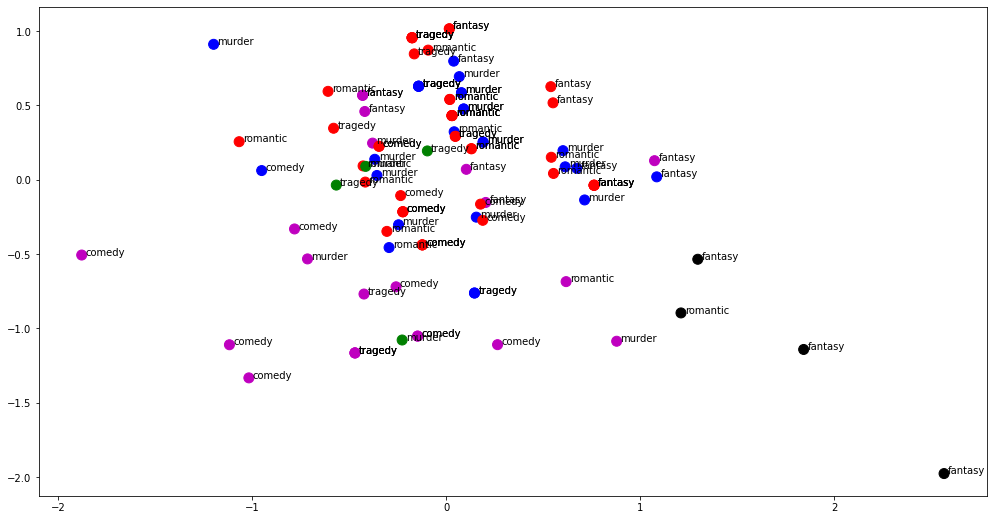

In [51]:
#plot the data
fig, ax = plt.subplots(figsize=(17, 9))

colours=["r","g","b","m","k"]
c= [colours[i] for i in k_means.labels_]

ax.scatter(x = plot_matrix[:,0], y = plot_matrix[:,1] , c=c, s=100)

for i, Tag in enumerate(Movies.Tag):
    ax.annotate(Tag, xy=(plot_matrix[i,0]+0.02, plot_matrix[i,1]), size=10)


# Evaluate the clusteting - F measure

In [57]:
# factorial function
def fact(x):
    if x==1 or x==0:
        return 1
    else:
        return x*fact(x-1)
    
#Possible combinations function
def Comb(from_, choose_):
    return int(fact(from_)/ (fact(choose_)*fact(from_ - choose_)))
    

In [53]:
Movies.Cluster=k_means.labels_
Movies.head()

,Id,Title,Plot,Tag,Cluster
0,tt0833476,Jhoom Barabar Jhoom,The film begins with a mysterious Romani peopl...,romantic,0
1,tt0082770,Montenegro,"Marianne Faithfull sings ""The Ballad of Lucy J...",comedy,0
2,tt0277689,Elektra,"After being killed in Daredevil, Elektra Natch...",tragedy,1
3,tt0418325,Die Wilden Kerle 2,In the English translation of the Wild Soccer ...,fantasy,0
4,tt1851988,Ko,Ashwin Kumar (Jiiva) is a photojournalist work...,murder,2


In [58]:
#create pivot table 
index_list = Movies.groupby("Tag")["Cluster"].value_counts().index
values_list = Movies.groupby("Tag")["Cluster"].value_counts().values
cluster_size = len(set(k_means.labels_))
columns = (set(k_means.labels_))
rows = genres
pivot_t = pd.DataFrame(index = rows, columns = columns)

#fill in the pivot table
for i,entry in enumerate(index_list):
    pivot_t.loc[entry]=values_list[i]
#replace Nan values with 0
pivot_t.fillna(value=0, inplace = True)




In [55]:
pivot_t

,0,1,2,3,4
comedy,11,0,1,8,0
murder,0,2,15,3,0
romantic,16,0,2,1,1
tragedy,8,2,6,4,0
fantasy,8,0,3,6,3


In [59]:
pivot_t.iloc[0,2]

1

In [60]:
Comb(8,2)+Comb(16,2)+Comb(3,2)+Comb(4,2)

157

In [66]:
#useful link for the explantion of the calculation 
#https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html  


#check if there are more than one clusters created. 
#if clusters<2, this validation cannot be performed.
if cluster_size<2:
    print("There are not enough clusters(<2) to perform this accuracy vaidation. Add more clusters.")
else:
#TP_FP_TN_FN is the total combinations out of N documents. Anty two docuemnts from any 
#random seletion of two clusters will fall in this total combinations

#TP_FP_TN_FN = N(CHOOSE)2
#Choose expresion = N!/2!*(N-2)!
    TP_FP_TN_FN = Comb(len(Movies),2)

    #TP_FP, check all clusters for the combiation of two documents within each cluster
    # the document combinations is the total true positive and false positive as a 
    #selection of two documents within a clusters could be either TP or FP
    TP_FP=0
    for i in range(cluster_size):
        N = int(pd.Series(k_means.labels_).value_counts()[i]) 
        TP_FP += Comb(N,2)
        
    #TP is the combination of similar documents within each cluster
    #we use the pivot table to search easily thought the clusters
    TP=0
    for c in range(pivot_t.shape[1]):
        for r in range(pivot_t.shape[0]):
            if pivot_t.iloc[r,c]<2:
                continue
            else:
                N = int(pivot_t.iloc[r,c])
                TP+=Comb(N,2)
    
    #FP can be easily calculated as FP = (TP+FP) - TP
    FP = TP_FP - TP
    
    #FN can be calculated by looping through the clusters and checkign for the combinations for each document tag 
    #between the clusters. Similar tags in differrent clusters will give us the combinations.
    #for a given X document tag, checking all clusters for the combination pairs that belong to the X tag,
    #gives thus the TP + FN sum. Since if N similar entries are in the same cluster can be selected in Nc2 combinations
    #for the True Positive sum. If N similar entries are in different clusters can be selected in Nc2 combinations
    #for the False Negative sum 
    TP_FN=0
    total = pivot_t.sum(axis=1)
    for sum_ in summary:
        TP_FN += Comb(sum_, 2)
    FN = TP_FN - TP
    
    #True negative is then calculated as follows
    TN = TP_FP_TN_FN - TP - FP - FN
                


In [67]:
#calculate precision
P = TP/ (TP+FP)
#calculate recall
R = TP/ (TP+FN)
# Fscore, parameter b >1 will give emphasis to recall for penalising False Negatives
b = 4
F = ((np.power(b,2) +1 ) * (P*R)) / (np.power(b,2)*P + R)
F

0.41947655267413314